<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [264]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [265]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [266]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [267]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [268]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [269]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

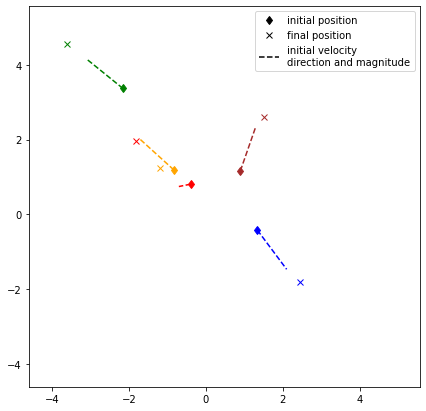

In [270]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [271]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [272]:
print(len(positions_train))

10000


In [273]:
# train_data = np.empty((10000, 5, 5))
# train_labels = np.empty((10000, 5, 2))
# for sim in range(len(positions_train)):
#     for i in range(5):
#         train_data[sim][i][0] = positions_train[sim][0][0][i]
#         train_data[sim][i][1] = positions_train[sim][0][1][i]
#         train_data[sim][i][2] = velocities_train[sim][0][0][i]
#         train_data[sim][i][3] = velocities_train[sim][0][1][i]
#         train_data[sim][i][4] = charges_train[sim][i]
#         train_labels[sim][i][0] = positions_train[sim][1][0][i]
#         train_labels[sim][i][1] = positions_train[sim][1][1][i]

In [274]:
positions_train.shape

(10000, 4, 2, 5)

In [275]:
import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
import numpy as np

class MyDataset(Dataset):
    def __init__(self, initial_pos, final_pos, initial_v, charges):
        self.initial_pos = torch.FloatTensor(initial_pos)
        self.final_pos = torch.FloatTensor(final_pos)
        self.initial_v = torch.FloatTensor(initial_v)
        self.charges = torch.FloatTensor(charges)
        
    def __getitem__(self, index):
        position = self.initial_pos[index]
        final = self.final_pos[index]
        velocity = self.initial_v[index]
        charge = self.charges[index]

        return position, final, velocity, charge
   
    def __len__(self):
        return len(self.initial_pos)

In [276]:
# Dataset Formation and DataLoader
initial_pos = positions_train[:,0,:,:]
final_pos = positions_train[:,1,:,:]
initial_v = velocities_train[:,0,:,:]
charges = charges_train[:,:,0]

val_initial_pos = positions_valid[:,0,:,:]
val_final_pos = positions_valid[:,1,:,:]
val_initial_v = velocities_valid[:,0,:,:]
val_charges = charges_valid[:,:,0]

train_data = MyDataset(initial_pos, final_pos, initial_v, charges)
val_data = MyDataset(val_initial_pos, val_final_pos, val_initial_v, val_charges)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1)

In [277]:
next(iter(train_loader))

[tensor([[[-1.9361,  3.6532, -4.5496, -3.0958,  0.1073],
          [-0.2276, -2.7631,  8.2998, -3.0921, -2.8976]]]),
 tensor([[[-2.3387,  4.4387, -5.1946, -4.0422,  0.4396],
          [-0.2173, -2.9732,  9.4907, -3.3710, -3.1883]]]),
 tensor([[[-0.7878,  1.5892, -1.2906, -1.9173,  0.6539],
          [ 0.0267, -0.4211,  2.3834, -0.5785, -0.5676]]]),
 tensor([[-1.,  1.,  1.,  1., -1.]])]

In [278]:
test_initial_pos = positions_test[:,0,:,:]
test_final_pos = positions_test[:,1,:,:]
test_initial_v = velocities_test[:,0,:,:]
test_charges = charges_test[:,:,0]

test_data = MyDataset(test_initial_pos, test_final_pos, test_initial_v, test_charges)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

In [279]:
def input_target(position, final, velocity, charge):
    initial_x = position[0][0][:]
    initial_y = position[0][1][:]
    final_x = final[0][0][:]
    final_y = final[0][1][:]
    v_x = velocity[0][0][:]
    v_y = velocity[0][1][:]
    ch = charge[0][:]

    input = torch.cat((initial_x, initial_y, v_x, v_y, ch))
    target = torch.cat((final_x, final_y))

    return input, target

# Model Implementation

In [280]:
import torch.nn as nn
from torch import optim
import torch
import torch.nn.functional as F

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(25, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )

  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [281]:
# Initialize the MLP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP()
model = model.to(device)

# Define the loss function and optimizer

In [282]:
# saving and loading checkpoint mechanisms
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'MLP-checkpoint.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [283]:
print(len(train_loader))

10000


# Model Training

In [284]:
import tqdm, time

# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    best_val_acc = 0.0
    epoch_best = 0
    epoch_val_best = 0
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        tr_acc = []
        model.train()
        print("Starting epoch " + str(epoch+1))
        # ============ Training ============ #
        for position, final, velocity, charge in train_loader:
            #plot_case(99,train_data,labels)
            initial_pos, target_pos = input_target(position, final, velocity, charge)
            initial_pos = initial_pos.to(device)
            target_pos = target_pos.to(device)
            #case_loss = 0.0
            #print(initial_pos)
            optimizer.zero_grad()
            outputs = model(initial_pos)
            loss = criterion(outputs, target_pos)

            #case_loss += loss.item()
            # Backward and optimize
            loss.backward()
            optimizer.step()

            #print(outputs, target_pos)
            running_loss += loss.item()
            #print(running_loss)
            #breakpoint()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # ============ Validation ============ #
        val_running_loss = 0.0
        va_acc = []
        with torch.no_grad():
            model.eval()
            for position, final, velocity, charge in val_loader:
                #case_loss = 0.0
                initial_pos, target_pos = input_target(position, final, velocity, charge)
                initial_pos = initial_pos.to(device)
                target_pos = target_pos.to(device)
                outputs = model(initial_pos)
                loss = criterion(outputs, target_pos)

                #case_loss += loss.item()

                val_running_loss += loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, elapsed_time: {:.4f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss, time.time()-start_time))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epoch_val_best = epoch+1
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses, best_val_loss, epoch_val_best

In [285]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Evaluation



In [286]:
from torchmetrics import R2Score
r2score = R2Score().to(device)

# ============ Testing ============ #
def eval(model, test_loader, criterion):
    with torch.no_grad():
        correct = 0
        count = 0
        test_loss = 0.0
        r2_score = 0.0
        for position, final, velocity, charge in test_loader:
            initial_pos, target_pos = input_target(position, final, velocity, charge)
            initial_pos = initial_pos.to(device)
            target_pos = target_pos.to(device)

            outputs = model(initial_pos)
            rmse_loss = torch.sqrt(criterion(outputs, target_pos))
            score = r2score(outputs, target_pos)

            #case_loss += loss.item()

            test_loss += rmse_loss.item()
            r2_score += score
            count+=1
            if count % 200 == 0:
                print("Output pos: ", outputs)
                print("Actual pos: ", target_pos)
                print(f"RMSE Loss after {count} simulations:", test_loss/count)
                print("\n")

    avg_test_loss = test_loss / len(test_loader)
    avg_r2_score = r2_score / len(test_loader)
    return avg_test_loss, avg_r2_score

In [287]:
# actual training
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20
criterion = nn.MSELoss()

save_path = 'MLP-checkpoint.pt'
train_losses, val_losses, best_val_loss, epoch_loss = train(model, train_loader, val_loader, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/20], train_loss: 2.9284, val_loss: 0.4159, elapsed_time: 19.3825
Model saved to ==> MLP-checkpoint.pt
Starting epoch 2
Epoch [2/20], train_loss: 0.2127, val_loss: 0.1306, elapsed_time: 17.5819
Model saved to ==> MLP-checkpoint.pt
Starting epoch 3
Epoch [3/20], train_loss: 0.1091, val_loss: 0.0936, elapsed_time: 17.8520
Model saved to ==> MLP-checkpoint.pt
Starting epoch 4
Epoch [4/20], train_loss: 0.0842, val_loss: 0.0771, elapsed_time: 17.7298
Model saved to ==> MLP-checkpoint.pt
Starting epoch 5
Epoch [5/20], train_loss: 0.0704, val_loss: 0.0661, elapsed_time: 17.4892
Model saved to ==> MLP-checkpoint.pt
Starting epoch 6
Epoch [6/20], train_loss: 0.0605, val_loss: 0.0578, elapsed_time: 17.7096
Model saved to ==> MLP-checkpoint.pt
Starting epoch 7
Epoch [7/20], train_loss: 0.0531, val_loss: 0.0512, elapsed_time: 18.1713
Model saved to ==> MLP-checkpoint.pt
Starting epoch 8
Epoch [8/20], train_loss: 0.0475, val_loss: 0.0462, elapsed_time: 17.7920
Model saved t

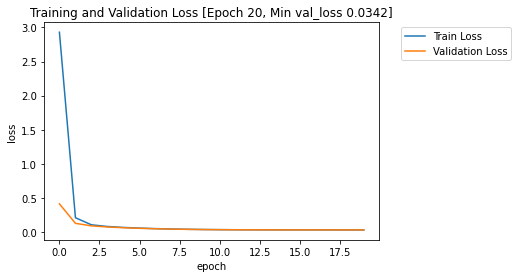

In [288]:
# plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss [Epoch {}, Min val_loss {:.4f}]".format(epoch_loss, best_val_loss))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [289]:
# Testing on previously trained model
import torch.optim as optim
load_model = MLP().to(device)
load_optimizer = optim.Adam(model.parameters(),lr=1e-4)

best_val_loss = load_checkpoint(load_model, load_optimizer)

print('Best val_loss: {:.8f}'.format(best_val_loss))

test_loss, r2_score = eval(load_model, test_loader, criterion)
print('RMSE Loss on test data: {:.8f}'.format(test_loss))
print('R2_score: {:.4f}'.format(r2_score))

Model loaded from <== MLP-checkpoint.pt
Best val_loss: 0.03424508
Output pos:  tensor([ 1.8352,  5.1547, -1.8730, -3.7129, -3.8293,  0.6156, -0.2796, -0.7434,
         1.0825,  0.5758], device='cuda:0')
Actual pos:  tensor([ 1.9267,  5.2441, -2.0995, -3.6937, -3.7919,  0.5924, -0.2596, -0.6607,
         0.4987,  1.0714], device='cuda:0')
RMSE Loss after 200 simulations: 0.1766954726912081


Output pos:  tensor([-1.1778, -0.4585, -0.0711, -1.6907, -0.2009,  2.5200, -1.1722,  1.4007,
        -1.5762,  0.4866], device='cuda:0')
Actual pos:  tensor([-1.0491, -0.4990, -0.2193, -1.5453, -0.2531,  2.5525, -1.4089,  0.9582,
        -1.2828,  0.8462], device='cuda:0')
RMSE Loss after 400 simulations: 0.16851513099856674


Output pos:  tensor([ 4.2054, -1.4931, -1.2205,  5.5911, -5.6316,  4.6532, -2.9134, -4.2362,
        -1.9394, -0.9225], device='cuda:0')
Actual pos:  tensor([ 4.2530, -1.5541, -1.3335,  5.5955, -5.6154,  4.7707, -2.9260, -4.3480,
        -1.8959, -1.0358], device='cuda:0')
RMS